<a href="https://colab.research.google.com/github/Ipsit1234/QML-HEP-Evaluation-Test-GSOC-2021/blob/main/QML_HEP_GSoC_2021_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task II: Quantum Generative Adversarial Network (QGAN) Part
You will explore how best to apply a quantum generative adversarial network
(QGAN) to solve a High Energy Data analysis issue, more specifically, separating
the signal events from the background events. You should use the Google Cirq and
Tensorflow Quantum (TFQ) libraries for this task.  
A set of input samples (simulated with Delphes) is provided in NumPy NPZ format
[Download Input](https://drive.google.com/file/d/1r_MZB_crfpij6r3SxPDeU_3JD6t6AxAj/view). In the input file, there are only 100 samples for training and 100
samples for testing so it won’t take much computing resources to accomplish this
task. The signal events are labeled with 1 while the background events are labeled
with 0.  
Be sure to show that you understand how to fine tune your machine learning model
to improve the performance. The performance can be evaluated with classification
accuracy or Area Under ROC Curve (AUC).

## Downloading the dataset

In [1]:
!gdown --id 1r_MZB_crfpij6r3SxPDeU_3JD6t6AxAj -O events.npz

Downloading...
From: https://drive.google.com/uc?id=1r_MZB_crfpij6r3SxPDeU_3JD6t6AxAj
To: /content/events.npz
100% 9.14k/9.14k [00:00<00:00, 8.67MB/s]


## Setting up the required libraries

In [2]:
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Loading the data

In [3]:
data = np.load('./events.npz', allow_pickle=True)
training_input = data['training_input']
test_input = data['test_input']

In [4]:
training_input

array({'0': array([[-0.43079088,  0.86834819, -0.92614721, -0.92662029, -0.56900862],
       [ 0.33924198,  0.56155499,  0.93097459, -0.91631726, -0.54463516],
       [-0.42888879,  0.87064961, -0.92782179, -0.77533991, -0.58329176],
       [-0.43262871,  0.86128919, -0.92240878, -0.88048862, -0.49963115],
       [-0.99925345, -0.99949586,  0.07753685, -0.84218034, -0.5149399 ],
       [-0.99631106, -0.99775978,  0.0756427 , -0.54117216, -0.66299335],
       [-0.42645921,  0.87141204, -0.92908723, -0.52650143, -0.62187526],
       [ 0.34317906,  0.57125045,  0.92638556, -0.85113425, -0.40170562],
       [-0.99904849, -0.99933931,  0.07737929, -0.81161066, -0.53550246],
       [ 0.3371327 ,  0.55874622,  0.92996976, -0.9117092 , -0.50996097],
       [ 0.89649306, -0.95523176, -0.66298651, -0.71276678, -0.62698893],
       [ 0.34293232,  0.56408047,  0.93448436, -0.88789589, -0.56154273],
       [-0.43055876,  0.86615566, -0.92532229, -0.82531102, -0.61433506],
       [ 0.33970589,  0.56

In [5]:
def prepare_data(training_input, test_input):
  x_train_0 = training_input.item()['0']
  x_train_1 = training_input.item()['1']
  x_test_0 = test_input.item()['0']
  x_test_1 = test_input.item()['1']
  x_train = np.zeros((len(x_train_0) + len(x_train_1), x_train_0.shape[1]), dtype=np.float32)
  x_test = np.zeros((len(x_test_0) + len(x_test_1), x_test_0.shape[1]), dtype=np.float32)
  y_train = np.zeros((len(x_train_0) + len(x_train_1),), dtype=np.int32)
  y_test = np.zeros((len(x_test_0) + len(x_test_1),), dtype=np.int32)
  x_train[:len(x_train_0), :] = x_train_0
  x_train[len(x_train_0):, :] = x_train_1
  y_train[:len(x_train_0)] = 0
  y_train[len(x_train_0):] = 1

  x_test[:len(x_test_0), :] = x_test_0
  x_test[len(x_test_0):, :] = x_test_1
  y_test[:len(x_test_0)] = 0
  y_test[len(x_test_0):] = 1

  idx1 = np.random.permutation(len(x_train))
  idx2 = np.random.permutation(len(x_test))
  x_train, y_train = x_train[idx1], y_train[idx1]
  x_test, y_test = x_test[idx2], y_test[idx2]

  print('Shape of the training set:', x_train.shape)
  print('Shape of the test set:', x_test.shape)

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = prepare_data(training_input, test_input)

Shape of the training set: (100, 5)
Shape of the test set: (100, 5)


## Approach
We will make use of a Quantum GAN in the following:
1. Train a GAN to produce samples that look like they came from quantum circuits.
2. Add a classification path to the discriminator and minimize both the minimax loss and  classification loss.
3. We will use a random quantum circuit to generate random inputs for the generator. The intution behind this is that the data that was provided are the results (measurements) taken from some quantum experiment. So if we succeed in training a GAN which generates outputs similar to the experimental data, this will help in identifying new or other possible outcomes of the same quantum experiment which have been missed in the dataset provided.
4. Simultaneously training the discriminator to classify signal events and background events will help in identifying the signal events generated from the fully trained generator.

## Data Generation
As provided in the dataset, each datapoint is 5-dimensional. Hence we will use 5 qubits and pass them through a random quantum circuit and then use these measurements as inputs to the GAN

In [6]:
def generate_circuit(qubits):
  """Generate a random circuit on qubits."""
  random_circuit = cirq.generate_boixo_2018_supremacy_circuits_v2(qubits, cz_depth=2, seed=123242)
  return random_circuit

def generate_data(circuit, n_samples):
  """Draw `n_samples` samples from circuit into a tf.Tensor."""
  return tf.squeeze(tfq.layers.Sample()(circuit, repetitions=n_samples).to_tensor())

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


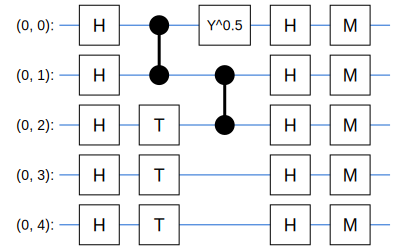

In [7]:
# sample data and circuit structure
qubits = cirq.GridQubit.rect(1, 5)
random_circuit_m = generate_circuit(qubits) + cirq.measure_each(*qubits)
SVGCircuit(random_circuit_m)

In [8]:
generate_data(random_circuit_m, 10)

<tf.Tensor: shape=(10, 5), dtype=int8, numpy=
array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0]], dtype=int8)>

We will generate 200 random training data

In [9]:
N_SAMPLES = 200
N_QUBITS = 5
QUBITS = cirq.GridQubit.rect(1, N_QUBITS)
REFERENCE_CIRCUIT = generate_circuit(QUBITS)
random_data = generate_data(REFERENCE_CIRCUIT, N_SAMPLES)
random_data

<tf.Tensor: shape=(200, 5), dtype=int8, numpy=
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 

## Building a Model
This GAN will be used to produce measurements corresponding to signal/background events.

In [10]:
def make_generator():
  """Construct generator model."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(256, use_bias=False, input_shape=(N_QUBITS,), activation='elu'))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(N_QUBITS, activation=tf.keras.activations.tanh))
  return model

def make_discriminator():
  """Construct discriminator model along with a classifier."""
  inp = tf.keras.Input(shape=(N_QUBITS, ), dtype=tf.float32)
  out = tf.keras.layers.Dense(256, use_bias=False, activation='elu')(inp)
  out = tf.keras.layers.Dense(128, activation='relu')(out)
  out = tf.keras.layers.Dropout(0.4)(out)
  out = tf.keras.layers.Dense(64, activation='relu')(out)
  out = tf.keras.layers.Dropout(0.3)(out)
  classification = tf.keras.layers.Dense(2, activation='softmax')(out)
  discrimination = tf.keras.layers.Dense(1, activation='sigmoid')(out)
  model = tf.keras.Model(inputs=[inp], outputs=[discrimination, classification])
  return model

Let us instantiate our models, define the losses and define the `train_step` function which will be executed in each epoch

In [11]:
generator = make_generator()
discriminator = make_discriminator()

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  """Computes the discriminator loss."""
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  """Compute the generator loss.""" 
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [13]:
BATCH_SIZE = 16
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# auc = tf.keras.metrics.AUC()
@tf.function
def train_step(images, labels, noise):
  """Run train step on provided image batch."""
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_data = generator(noise, training=True)

    real_output, real_preds = discriminator(images, training=True)
    fake_output, fake_preds = discriminator(generated_data, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    disc_loss = disc_loss + bce(tf.one_hot(tf.squeeze(labels), depth=2), real_preds)
  
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  # auc.update_state(tf.one_hot(tf.squeeze(labels), depth=2), real_preds)

  return gen_loss, disc_loss

In [14]:
def train(data, labels, noise, epochs):
  """Launch full training for the given number of epochs."""
  batched_data = tf.data.Dataset.from_tensor_slices(data).batch(BATCH_SIZE)
  batched_labels = tf.data.Dataset.from_tensor_slices(labels).batch(BATCH_SIZE)
  batched_noise = tf.data.Dataset.from_tensor_slices(noise).batch(BATCH_SIZE)
  AUC = tf.keras.metrics.AUC()
  g_losses = []
  d_losses = []
  # aucs = []
  for epoch in range(epochs):
    g_epoch_losses = []
    d_epoch_losses = []
    # aucs_epoch = []
    for i, (data_batch, labels_batch, noise_batch) in enumerate(zip(batched_data, batched_labels, batched_noise)):
      gl, dl = train_step(data_batch, labels_batch, noise_batch)
      g_epoch_losses.append(gl)
      d_epoch_losses.append(dl)
      # aucs_epoch.append(auc_roc)
    
    g_losses.append(tf.reduce_mean(g_epoch_losses))
    d_losses.append(tf.reduce_mean(d_epoch_losses))
    print('Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch, tf.reduce_mean(g_epoch_losses), tf.reduce_mean(d_epoch_losses)))
    # aucs.append(tf.reduce_mean(aucs_epoch))
  return g_losses, d_losses

In [15]:
gen_losses, disc_losses = train(x_train, y_train, random_data, 2000)

Epoch: 0, Generator Loss: 0.47288545966148376, Discriminator Loss: 2.1426262855529785
Epoch: 1, Generator Loss: 0.47159355878829956, Discriminator Loss: 2.1388280391693115
Epoch: 2, Generator Loss: 0.470787912607193, Discriminator Loss: 2.0825936794281006
Epoch: 3, Generator Loss: 0.4702128767967224, Discriminator Loss: 2.075483798980713
Epoch: 4, Generator Loss: 0.47020336985588074, Discriminator Loss: 2.0505168437957764
Epoch: 5, Generator Loss: 0.4700762927532196, Discriminator Loss: 2.022904872894287
Epoch: 6, Generator Loss: 0.46946173906326294, Discriminator Loss: 2.0530457496643066
Epoch: 7, Generator Loss: 0.4677629768848419, Discriminator Loss: 2.0332977771759033
Epoch: 8, Generator Loss: 0.4693600833415985, Discriminator Loss: 2.048710346221924
Epoch: 9, Generator Loss: 0.4706823527812958, Discriminator Loss: 2.019632339477539
Epoch: 10, Generator Loss: 0.4711288809776306, Discriminator Loss: 2.0153427124023438
Epoch: 11, Generator Loss: 0.47589582204818726, Discriminator Los

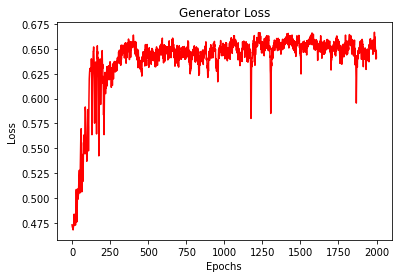

In [16]:
plt.title('Generator Loss')
plt.plot(gen_losses, 'r-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

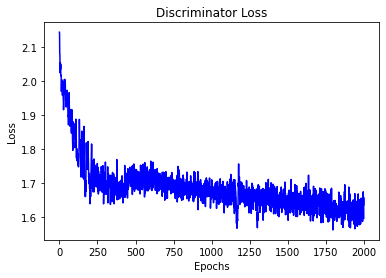

In [17]:
plt.title('Discriminator Loss')
plt.plot(disc_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Using the Discriminator for Classification
We will now evaluate the performance of discriminator on the original training data as a classifier. We will check both the classification accuracy and Area Under ROC Curve as the metrics.

In [18]:
_, train_predictions = discriminator(tf.convert_to_tensor(x_train))
train_predictions.shape

TensorShape([100, 2])

In [19]:
binary_accuracy = tf.keras.metrics.BinaryAccuracy()
binary_accuracy.update_state(tf.one_hot(tf.squeeze(y_train), depth=2), train_predictions)
print('Training Accuracy: %.4f %s' % (binary_accuracy.result().numpy()*100, '%'))

Training Accuracy: 88.0000 %


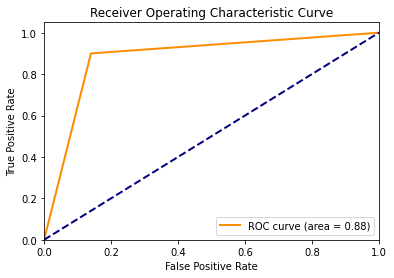

In [20]:
fpr, tpr, _ = roc_curve(y_train, tf.argmax(train_predictions,1).numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
_, test_predictions = discriminator(tf.convert_to_tensor(x_test))
test_predictions.shape

TensorShape([100, 2])

In [22]:
binary_accuracy = tf.keras.metrics.BinaryAccuracy()
binary_accuracy.update_state(tf.one_hot(tf.squeeze(y_test), depth=2), test_predictions)
print('Test Accuracy: %.4f %s' % (binary_accuracy.result().numpy()*100, '%'))

Test Accuracy: 69.0000 %


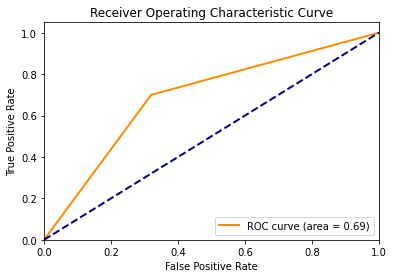

In [23]:
fpr, tpr, _ = roc_curve(y_test, tf.argmax(test_predictions,1).numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

We will now look at the predictions on the generated synthetic data.

In [24]:
generator_outputs = generator(random_data)
generator_outputs.shape

TensorShape([200, 5])

In [25]:
_, predictions_synthetic = discriminator(generator_outputs)
predictions_synthetic.shape

TensorShape([200, 2])

In [26]:
predicted_labels_synthetic = tf.argmax(predictions_synthetic, 1)
predicted_labels_synthetic[:20]

<tf.Tensor: shape=(20,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])>

## Improving the Performance
It can be seen from the loss vs iterations plots that the generator has more or less converged, but the discriminator hasn't. The AUC scores suggest that the model is actually learning. This can be improved in the fillowing ways:
1. Use slightly higher learning rates while training the discriminator.  
2. As the generator converged, we can take the synthetic data generated by it and add to our original training set. We can again start training the GAN so that the discriminator becomes more robust. 
3. Training for a larger number of epochs.
4. Using adaptive learning rates and learning rate scheduling.